# Contrast
Contrast is really just a measure of the difference between the maximum and minimum pixel intensities in an image. So, in order to increase the contrast in an image, we need to increase the distance between the maximum and minimum pixel intensities.

We'll take a look at a few different contrast adjustment algorithms starting with contrast/histogram stretching.

**Contrast Stretching / Histogram Stretching**

As the name implies, this is really just the process of taking the existing intensity values in the image and "stretching" them to fit the entire range of potential values - [0, 255].

**Histogram Equalization**

While histogram stretching modifies the range of intensity values to spread over the entire possible range, histogram equalization creates a uniform distribution of the histogram values.

Histogram equalization by no means guarantees improved results. Converting the intensity values into a uniform distribution may very well decrease contrast or introduce additional noise into the image.

**Nonlinear Stretching**

When we were discussing contrast stretching, we were stretching all parts of the histogram equally. Nonlinear stretching is essentially the same approach, but it'll use some other function to selectively stretch different parts of the histogram differently. For example, an implementation might use a logarithmic function to stretch the histogram instead.

**Histogram Specification**

This approach is closely related to histogram equalization. Instead of creating a uniform distribution, histogram specification enables you to transform an image's histogram to match some other histogram you specify. So, histogram equalization is just one flavor of this approach where the provided histogram is uniformly distributed. Instead, this approach enables you to pass in any histogram to match.

**Adaptive Histogram Modification**

This approach involves creating several histograms that each correspond to different parts of the source image. This allows you to have much more granular contrast adjustments. This approach is often used when you want to provide local contrast adjustments or more generally refine the edges in your image.

Thanks to [Hackernoon] (https://hackernoon.com/understanding-image-contrast-stretching-3b9c9d9b5f2c) for the original article.

In [571]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
from scipy import ndimage
from scipy.ndimage import median_filter

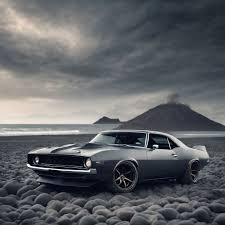

In [277]:
img = cv2.imread('/content/car.jpeg')
cv2_imshow(img)

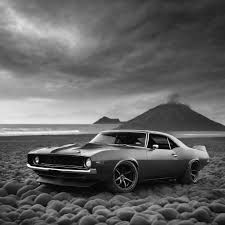

In [278]:
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(grey_img)

# histogram equalization using cv2

In [279]:
def plot_histogram(image):
  fig, ax = plt.subplots()

  histogram = [0] * 256

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      histogram[image[i, j]] += 1

  # Plot the histogram
  plt.xticks(rotation=90)

  sns.barplot(x=list(range(256)), y=histogram)

  every_nth = 25
  for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [280]:
def equalize_hist(image):
  frequency = {}
  for i in range(256):
    frequency[i] = 0

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      intensity = image[i, j]

      if intensity in frequency:
        frequency[intensity] += 1
      else:
        frequency[intensity] = 1

  intensity_frequencies = [frequency[key] for key in sorted(frequency.keys())]

  cumulative_sum = 0
  index = 0

  cdf = []

  for intensityFrequency in intensity_frequencies:
    cumulative_sum += intensityFrequency
    cdf.append(cumulative_sum)
    index += 1

  # normalize the CDF to fit between a range of [0, 255]
  normalized_cdf = []

  for value in cdf:
    normalized_cdf.append((value - min(cdf)) / (max(cdf) - min(cdf)) * 255)

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      image[i, j] = int(normalized_cdf[image[i, j]])

  return image

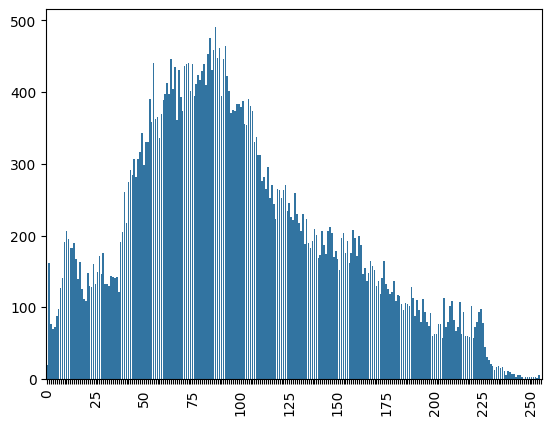

In [281]:
plot_histogram(grey_img)

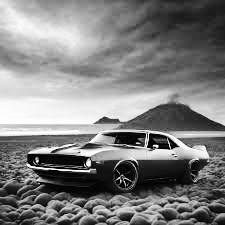

In [282]:
equalized_img = equalize_hist(grey_img)
cv2_imshow(equalized_img)

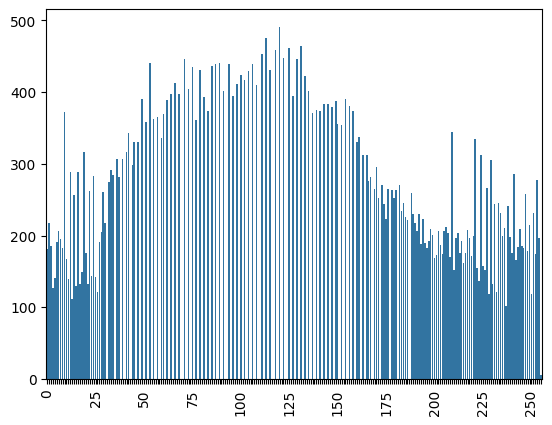

In [283]:
plot_histogram(equalized_img)

# histogram equalization using PIL
**Pseudocode**

1.   Iterate through all the pixels in the image.
2.   Count the frequency of each intensity value in a dictionary.
3.   Create an empty array of length 256.
4.   Using our dictionary, we'll fill in this array such that each index stores the probability of that intensity value occurring in the source image. For example, index 5 in the array will represent the probability with which an intensity of 5 appears in the input image.
5.   Create a cumulative distribution function.
Use the cumulative distribution function to transform the original pixel's value and compute the new pixel value in the output image.





In [306]:
# convert to gray scale
img = Image.open('/content/car.jpeg').convert('L')
output_img = Image.new('L', img.size)
width, height = img.size

In [307]:
def plot_histogram_PIL(image):
  fig, ax = plt.subplots()

  histogram = [0] * 256

  width, height = image.size

  for i in range(width):
    for j in range(height):
      intensity = image.getpixel((i, j))
      histogram[intensity] += 1

  # Plot the histogram
  plt.xticks(rotation=90)

  sns.barplot(x=list(range(256)), y=histogram)

  every_nth = 25
  for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

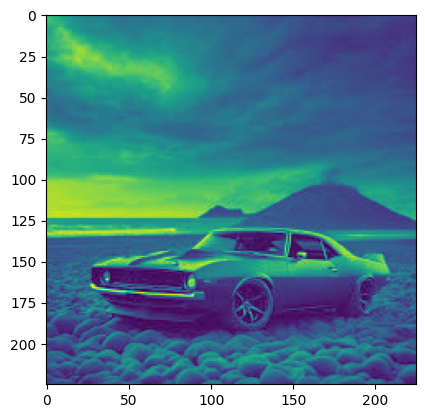

In [308]:
plt.imshow(img)

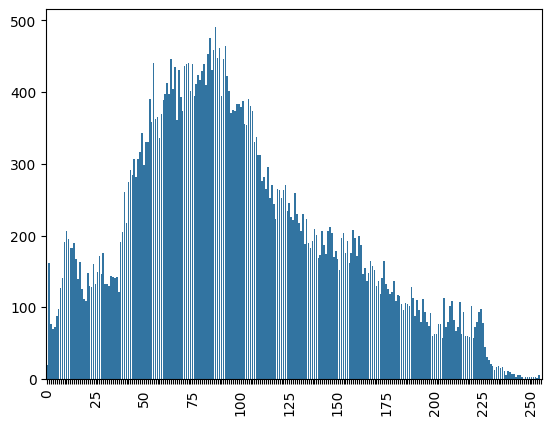

In [309]:
plot_histogram_PIL(img)

In [310]:
frequency = {}

# Fill the frequency count with 0s
for intensity in range(256):
  frequency[intensity] = 0

for i in range(width):
  for j in range(height):
    intensity = img.getpixel((i, j))

    if intensity in frequency:
      frequency[intensity] += 1
    else:
      frequency[intensity] = 1

intensity_frequencies = [frequency[key] for key in sorted(frequency.keys())]

cumulative_sum = 0
index = 0

cdf = [] # cumulative distribution function
for intensityFrequency in intensity_frequencies:
  cumulative_sum += intensityFrequency
  cdf.append(cumulative_sum)
  index += 1

# normalize the CDF to fit between a range of [0, 255]
#  use the values in the CDF to change the intensity of pixels in the original image. so we need our intensity values to be normalized to [0,255]

min_cdf = cdf[0]
max_cdf = cdf[-1]

normalized_cdf = []

for value in cdf:
  # We need to multiply by 255 as normalization gives us a value between 0 and 1
  normalized_cdf.append((value - min_cdf) * 255 / (max_cdf - min_cdf))

print(normalized_cdf)
print(len(normalized_cdf))

for i in range(width):
  for j in range(height):
    output_img.putpixel((i, j), int(normalized_cdf[img.getpixel((i, j))]))

output_img.save('histogramEqualization.jpg')

[0.0, 0.8163063668339723, 1.1992649092992926, 1.5469509544322808, 1.9097537841362684, 2.353179464885587, 2.8469944275382364, 3.486938307710548, 4.197427182547524, 5.159862466901158, 6.197881674109789, 7.180472671224756, 8.102596530055724, 9.024720388886694, 9.97707781685966, 10.818578824645298, 11.51898984310161, 12.340335138125914, 12.97020116191756, 13.534561119234873, 14.078765363790854, 14.824526735960163, 15.479587400703474, 16.124570209066118, 16.930798719519423, 17.600976168833736, 18.351776469193375, 19.213433189740346, 19.94911670552899, 20.83092913883729, 21.501106588151604, 22.171284037465913, 22.821305774018892, 23.546911433426867, 24.262439236454174, 24.97292811129115, 25.68845591431846, 26.298166225348773, 27.260601509702408, 28.293581788720704, 29.608742046397662, 30.70722839189029, 32.087894716041575, 33.554222819428524, 34.985278425483145, 36.53222937991543, 37.95320712958938, 39.500158084021656, 41.09245939216694, 42.82081176145121, 44.322412362170496, 45.985258664980

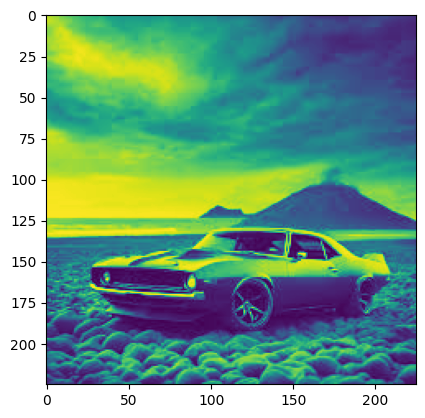

In [311]:
plt.imshow(output_img)

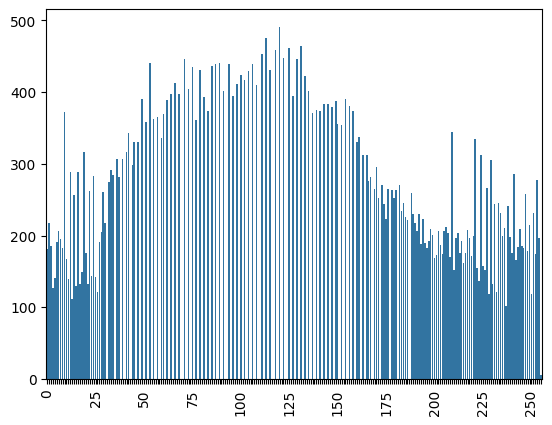

In [312]:
plot_histogram_PIL(output_img)

## Drawbacks of histogram equalization

Histogram equalization can have negative effects on the quality and interpretation of the image. Artifacts or distortions, such as **false edges, overshooting, or ringing**, may be introduced if the histogram is not smooth. Additionally, the **original brightness or color of the image may be altered**, and **the naturalness or realism of the image may be reduced**, making it look unnatural or exaggerated. Furthermore, **information or contrast in some regions or pixels may be lost due to them being mapped to the same value or compressed too much**.

# Histogram equalization on RGB image

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is not the proper way for equalization of contrast. **Equalization involves Intensity values of the image not the color components.** So for a simple RGB color image, HE should not be applied individually on each channel. Rather, it should be applied **such that intensity values are equalized without disturbing the color balance of the image**. So, the first step is to convert the color space of the image from RGB into one of the color spaces which separate intensity values from color components. Some of these are:
1.   HSV/HLS
2.   YUV
3. YCbCr

Thanks to (https://stackoverflow.com/questions/15007304/histogram-equalization-not-working-on-color-image-opencv)


YCbCr is a family of color spaces used as a part of the color image pipeline in video and digital photography systems. Y′ is the luma component and CB and CR are the blue-difference and red-difference chroma components. Y′ (with prime) is distinguished from Y, which is luminance, meaning that light intensity is nonlinearly encoded based on gamma corrected RGB primaries.

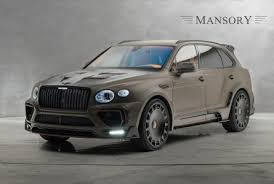

In [300]:
img = cv2.imread('/content/car_rgb.jpeg')
cv2_imshow(img)

In [301]:
def plot_histogram_rgb(image):
  """ plots the histogram of Y channel in Ycrcb color space """

  if len(image.shape) >= 3:  # Check if the image has at least 3 channels (RGB)
    # Convert the image to YCbCr color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Split the image into its Y, Cb, and Cr channels
    channels = cv2.split(ycrcb)

    plot_histogram(channels[0])

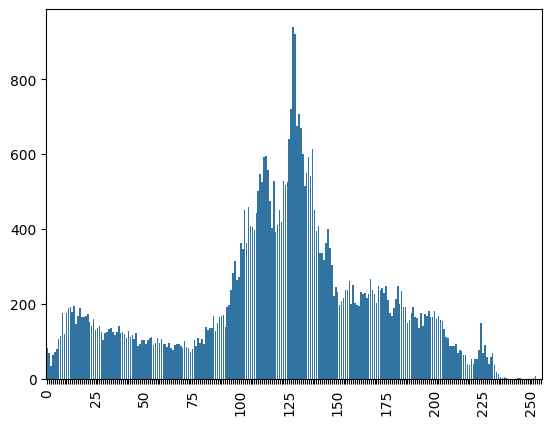

In [302]:
plot_histogram_rgb(img)

In [303]:
def equalize_intensity(image):
    if len(image.shape) >= 3:  # Check if the image has at least 3 channels (RGB)
        # Convert the image to YCbCr color space
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        # Split the image into its Y, Cb, and Cr channels
        channels = cv2.split(ycrcb)

        # Equalize the Y channel (brightness) using OpenCV's equalizeHist function
        equalize_hist(channels[0])

        # Merge the equalized Y channel with the original Cb and Cr channels
        merged = cv2.merge(channels)

        # Convert the merged image back to RGB color space
        equalizedImage = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)

        return equalizedImage

    else:
        return image  # Return the original image if it's not RGB

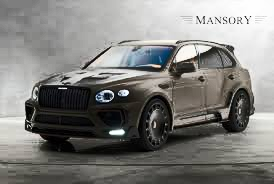

In [304]:
equalized_rgb_img = equalize_intensity(img)
cv2_imshow(equalized_rgb_img)

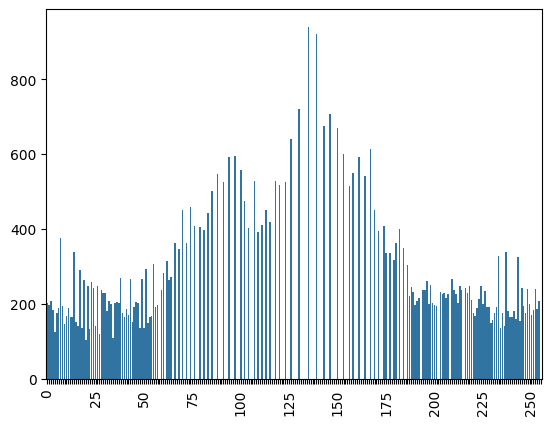

In [305]:
plot_histogram_rgb(equalized_rgb_img)

# Image noise

1. Gaussian Noise: This arises during acquisition. The sensor or CCD generates inherent noise due to the level of illumination and its own temperature. In addition to this, the electronic circuits connected to the sensor also inject their own level of electronic circuit noise.

2. Shot Noise: Also known as photon shot noise, this is caused due to a variation in the number of photons sensed by the CCD at any given exposure level. It is associated with the quantum processes inherent in both the generation of the photons and the conversion of those into electrons within the camera.

3. Salt and pepper noise: Immediately recognizable by dark pixels in bright areas and light pixels in dark areas. This type of noise is a result of converting videos from analog to digital or other errors in pixel interpretation, such as dead sensor elements.

4. Quantization noise: In the context of image processing, quantization is achieved by compressing a range of values into a single integer value or a smaller representative sample set. Quantization noise is typically caused by rounding errors during that process.

5. Film grain: This is a random physical texture produced on footage shot using film stock, which occurs because processed photographic celluloid contains small metallic silver particles. It doesn’t naturally occur on digital footage for obvious reasons, but can be added in post-processing to achieve the iconic look of footage shot on film stock. Pixop’s film grain filter does just that.

6. Anisotropic noise: This occurs when the sensor readout is sampled or quantized. It causes finer details to blend together, creates patterns that aren’t there, and/or interprets straight lines as jagged.

7. Periodic noise: This is a kind of interference noise, meaning it originates outside the camera. It occurs when natural or man-made signals interfere with the recorded signal and typically manifests as something that looks like a repeating pattern that has been overlaid on the original image.
(https://www.pixop.com/blog/image-noise-causes)

# Normalization

In computer vision, the pixel normalization technique is often used to speed up model learning. The normalization of an image consists in dividing each of its pixel values by the maximum value that a pixel can take (255 for an 8-bit image, 4095 for a 12-bit image, 65 535 for a 16-bit image).

The CT images are mainly encoded in 12 bits and gray levels.To normalize a CT image, each pixel value is divided by 4095, to obtain a value between [0; 1].
(https://www.imaios.com/en/resources/blog/ct-images-normalization-zero-centering-and-standardization)

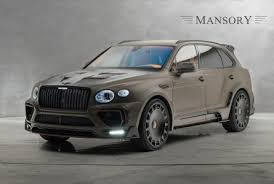

In [313]:
img = cv2.imread('/content/car_rgb.jpeg')
cv2_imshow(img)

In [316]:
def normalize(image):
    # normalize image values to range [0, 1]
    normalized_image = image / 255.0

    # standardize image values to mean 0 and standard deviation 1
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std

    return normalized_image, standardized_image

[[[0.48627451 0.48627451 0.48627451]
  [0.48627451 0.48627451 0.48627451]
  [0.48627451 0.48627451 0.48627451]
  ...
  [0.86666667 0.86666667 0.86666667]
  [0.85490196 0.85490196 0.85490196]
  [0.85490196 0.85490196 0.85490196]]

 [[0.48235294 0.48235294 0.48235294]
  [0.48627451 0.48627451 0.48627451]
  [0.48627451 0.48627451 0.48627451]
  ...
  [0.87058824 0.87058824 0.87058824]
  [0.85490196 0.85490196 0.85490196]
  [0.85490196 0.85490196 0.85490196]]

 [[0.48235294 0.48235294 0.48235294]
  [0.48235294 0.48235294 0.48235294]
  [0.48627451 0.48627451 0.48627451]
  ...
  [0.87058824 0.87058824 0.87058824]
  [0.85882353 0.85882353 0.85882353]
  [0.85882353 0.85882353 0.85882353]]

 ...

 [[0.42745098 0.45098039 0.47058824]
  [0.42745098 0.45098039 0.47058824]
  [0.42745098 0.45098039 0.47058824]
  ...
  [0.36862745 0.38431373 0.38823529]
  [0.34901961 0.36078431 0.37647059]
  [0.34901961 0.36078431 0.37647059]]

 [[0.43137255 0.45490196 0.4745098 ]
  [0.43137255 0.45490196 0.4745098 ]


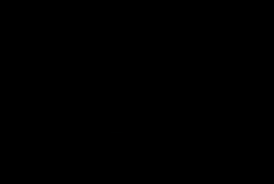

In [321]:
normalized_img, standardized_img = normalize(img)
print(normalized_img)
# The image is black because the values are in [0, 1]
cv2_imshow(normalized_img)

[[[ 0.08006866  0.08006866  0.08006866]
  [ 0.08006866  0.08006866  0.08006866]
  [ 0.08006866  0.08006866  0.08006866]
  ...
  [ 1.96176421  1.96176421  1.96176421]
  [ 1.90356744  1.90356744  1.90356744]
  [ 1.90356744  1.90356744  1.90356744]]

 [[ 0.06066973  0.06066973  0.06066973]
  [ 0.08006866  0.08006866  0.08006866]
  [ 0.08006866  0.08006866  0.08006866]
  ...
  [ 1.98116313  1.98116313  1.98116313]
  [ 1.90356744  1.90356744  1.90356744]
  [ 1.90356744  1.90356744  1.90356744]]

 [[ 0.06066973  0.06066973  0.06066973]
  [ 0.06066973  0.06066973  0.06066973]
  [ 0.08006866  0.08006866  0.08006866]
  ...
  [ 1.98116313  1.98116313  1.98116313]
  [ 1.92296636  1.92296636  1.92296636]
  [ 1.92296636  1.92296636  1.92296636]]

 ...

 [[-0.21091519 -0.09452165  0.00247296]
  [-0.21091519 -0.09452165  0.00247296]
  [-0.21091519 -0.09452165  0.00247296]
  ...
  [-0.50189904 -0.42430335 -0.40490443]
  [-0.59889366 -0.54069689 -0.4631012 ]
  [-0.59889366 -0.54069689 -0.4631012 ]]

 [

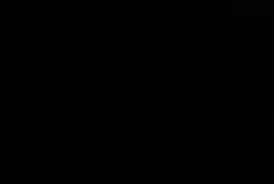

In [322]:
print(standardized_img) # The image is black because mean = 0 and standard deviation = 1.
cv2_imshow(standardized_img)

# shifting, rotating and  flipping the image

1. Shifting an image involves moving the entire image in a specific direction by a certain number of pixels.
2. Flipping an image involves reversing the order of pixels in the image along a specific axis.
3. Rotating an image involves rotating the entire image by a specific angle.

In [331]:
def shift_image(image, x_shift, y_shift=0):
    # Create a copy of the image
    shifted_image = np.roll(image, x_shift, axis=0)
    shifted_image = np.roll(shifted_image, y_shift, axis=1)

    # Clip the shifted image to the original dimensions
    shifted_image = shifted_image[:image.shape[0], :image.shape[1]]

    return shifted_image

def flip_image(image, direction='horizontal'):
    if direction == 'horizontal':
        return cv2.flip(image, 1)
    elif direction == 'vertical':
        return cv2.flip(image, 0)

def rotate_image(image, angle):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

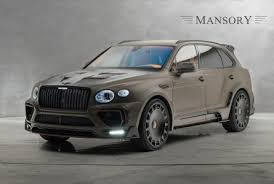

In [332]:
img = cv2.imread('/content/car_rgb.jpeg')
cv2_imshow(img)

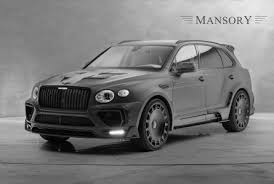

In [333]:
# Convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

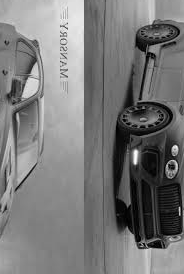

In [334]:
img = shift_image(img, 100)
img = flip_image(img, 'horizontal')
img = rotate_image(img, 90)
cv2_imshow(img)

# comparing manual and python histogram equalization

In [548]:
intensity_frequencies = [1,3,3,4,9,15,16,13]

cumulative_sum = 0
index = 0

cdf = []

for intensityFrequency in intensity_frequencies:
  cumulative_sum += intensityFrequency
  cdf.append(cumulative_sum)
  index += 1

# normalize the CDF to fit between a range of [0, 255]
normalized_cdf = []

for value in cdf:
  normalized_cdf.append((value - min(cdf)) / (max(cdf) - min(cdf)) * 255)

print(normalized_cdf)

[0.0, 12.142857142857142, 24.285714285714285, 40.476190476190474, 76.9047619047619, 137.61904761904762, 202.38095238095238, 255.0]


## manual HE
intensity_frequencies = [1,3,3,4,9,15,16,13]

cdf = [1, 4, 7, 11, 20, 35, 51, 64]

normalized_cdf = [0.0, 12.142857142857142, 24.285714285714285, 40.476190476190474, 76.9047619047619, 137.61904761904762, 202.38095238095238, 255.0]

The results are the same

# edge detection
An edge in an image is a significant local change in the image intensity. As the name suggests, edge detection is the process of detecting the edges in an image.

Discontinuities in depth, surface orientation, scene illumination variations, and material properties changes lead to discontinuities in image brightness. We get the set of curves that indicate the **boundaries of objects and surface markings**, and **curves that correspond to discontinuities in surface orientation**.
Thus, applying an edge detection algorithm to an image may **significantly reduce the amount of data to be processed and may therefore filter out information that may be regarded as less relevant while preserving the important structural properties of an image**.

**Sobel Operator**: It is a discrete differentiation operator. It computes the gradient approximation of image intensity function for image edge detection. At the pixels of an image, the Sobel operator produces either the normal to a vector or the corresponding gradient vector. It uses two 3 x 3 kernels or masks which are convolved with the input image to calculate the vertical and horizontal derivative approximations respectively

**Prewitt Operator**: This operator is almost similar to the sobel operator. It also detects vertical and horizontal edges of an image. It is one of the best ways to detect the orientation and magnitude of an image. It uses the kernels or masks

**Robert Operator**: This gradient-based operator computes the sum of squares of the differences between diagonally adjacent pixels in an image through discrete differentiation. Then the gradient approximation is made. It uses the following 2 x 2 kernels or masks

M**arr-Hildreth Operator or Laplacian of Gaussian (LoG)**: It is a gaussian-based operator which uses the Laplacian to take the second derivative of an image. This really works well when the transition of the grey level seems to be abrupt. It works on the zero-crossing method i.e when the second-order derivative crosses zero, then that particular location corresponds to a maximum level. It is called an edge location.

**Canny Operator**: It is a gaussian-based operator in detecting edges. This operator is not susceptible to noise. It extracts image features without affecting or altering the feature. Canny edge detector have advanced algorithm derived from the previous work of Laplacian of Gaussian operator. It is widely used an optimal edge detection technique. It detects edges based on three criteria:
* Low error rate
* Edge points must be accurately localized
* There should be just one single edge response
The Canny edge detection algorithm is composed of 5 steps:
1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Double threshold;
5. Edge Tracking by Hysteresis.

* https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
* https://www.analyticsvidhya.com/blog/2022/08/comprehensive-guide-to-edge-detection-algorithms/
* https://www.geeksforgeeks.org/image-edge-detection-operators-in-digital-image-processing/

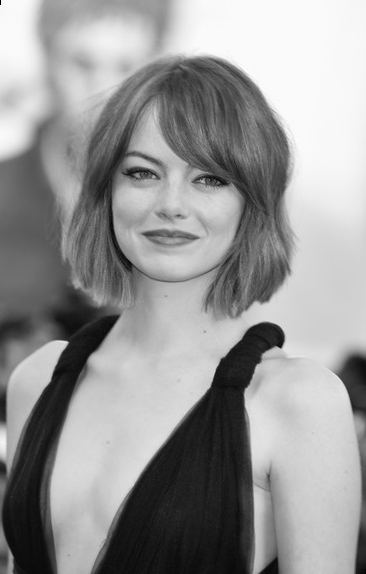

In [642]:
# Canny edge detector
img = cv2.imread('/content/edge_detection.jpg')
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(grey_img)

## 1. Noise Reduction

One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it.

In [643]:
def gaussian_kernel(size, sigma=1.0):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

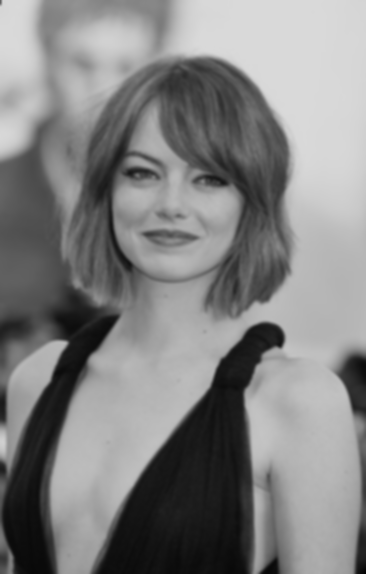

In [644]:
smoothed_img = ndimage.convolve(grey_img, gaussian_kernel(5, 1.4))
cv2_imshow(smoothed_img)

## 2. Gradient Calculation

Edges correspond to a change of pixels’ intensity.
To detect it, the easiest way is to apply filters that highlight this intensity change in both directions:
horizontal (x) and vertical (y)

In [645]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    # Equivalent to sqrt(x1**2 + x2**2), element-wise.
    # Gradient intensity
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    # Edge direction
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

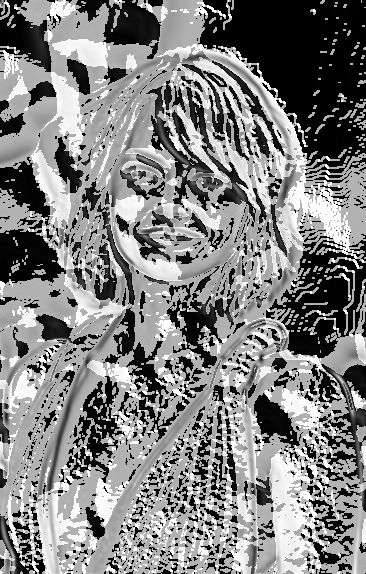

In [663]:
gradient, theta = sobel_filters(smoothed_img)
cv2_imshow(gradient)

In [660]:
print(theta)

[[0.      0.      0.      ... 0.785   0.      0.     ]
 [0.      0.      0.      ... 1.107   1.249   0.785  ]
 [0.446   0.1974  0.04974 ... 1.249   0.785   0.3218 ]
 ...
 [0.785   0.7974  0.      ... 1.507   1.503   1.543  ]
 [0.7812  0.802   0.8135  ... 1.508   1.512   1.551  ]
 [0.7935  0.8135  0.      ... 1.508   1.52    0.     ]]


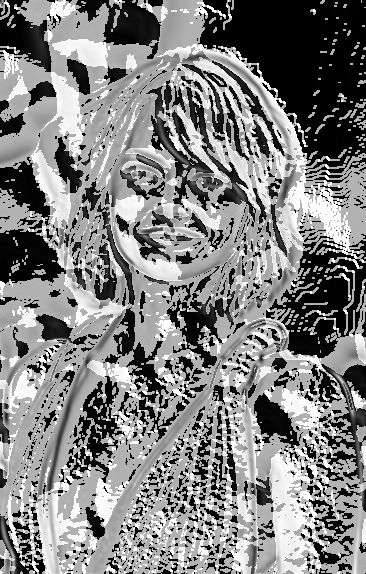

In [648]:
# Apply median filter to the gradient image
gradient_smoothed = median_filter(smoothed_img, 5)
cv2_imshow(gradient)

## 3. Non-Maximum Suppression

Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.
The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed.
Each pixel has 2 main criteria (edge direction in radians, and pixel intensity (between 0–255)). Based on these inputs the non-max-suppression steps are:

* Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;
* Identify the edge direction based on the angle value from the angle matrix;
* Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
* Return the image processed with the non-max suppression algorithm.

In [649]:
def non_max_suppression(img, D):
  M, N = img.shape
  Z = np.zeros((M,N))
  angle = D * 180. / np.pi
  angle[angle < 0] += 180

  for i in range(1, M-1):
    for j in range(1, N-1):
      try:
        q = 255
        r = 255

        #angle 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
          q = img[i, j+1]
          r = img[i, j-1]
        #angle 45
        elif (22.5 <= angle[i,j] < 67.5):
          q = img[i+1, j-1]
          r = img[i-1, j+1]
        #angle 90
        elif (67.5 <= angle[i,j] < 112.5):
          q = img[i+1, j]
          r = img[i-1, j]
        #angle 135
        elif (112.5 <= angle[i,j] < 157.5):
          q = img[i-1, j-1]
          r = img[i+1, j+1]

        if (img[i,j] >= q) and (img[i,j] >= r):
          Z[i,j] = img[i,j]
        else:
          Z[i,j] = 0

      except IndexError as e:
        pass

  return Z

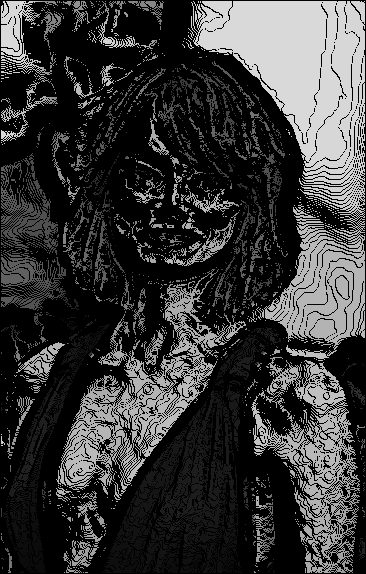

In [650]:
non_max_img = non_max_suppression(gradient_smoothed, theta)
cv2_imshow(non_max_img)

## 4. Double threshold

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

* Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
* Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
* Other pixels are considered as non-relevant for the edge.

In [651]:
def threshold(img, low_threshold_ratio = 0.05, high_threshold_ratio = 0.09, weak=25, strong=255):

  high_threshold = high_threshold_ratio * img.max()
  low_threshold = high_threshold * low_threshold_ratio

  M, N = img.shape
  res = np.zeros((M,N))

  strong_i, strong_j = np.where(img >= high_threshold)
  weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))

  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak

  return (res, weak, strong)

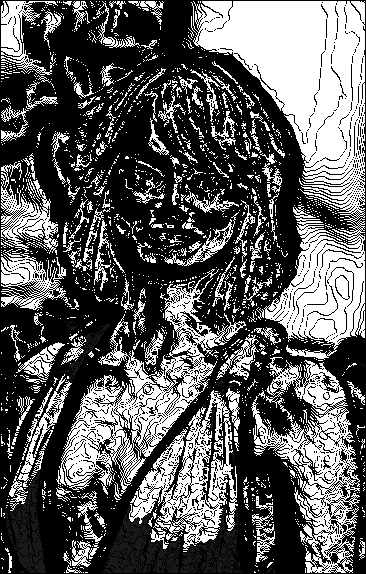

In [652]:
threshold_img, weak, strong = threshold(non_max_img, low_threshold_ratio = 0.05, high_threshold_ratio = 0.09, weak=25, strong=255)
cv2_imshow(threshold_img)

## 5. Edge Tracking by Hysteresis

the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [653]:
def hysteresis(img, weak, strong=255):
  M, N = img.shape
  for i in range(1, M-1):
    for j in range(1, N-1):
      if (img[i,j] == weak):
        try:
          if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
              or (img[i, j-1] == strong) or (img[i, j+1] == strong)
              or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
            img[i, j] = strong
          else:
            img[i, j] = 0
        except IndexError as e:
          pass

  return img

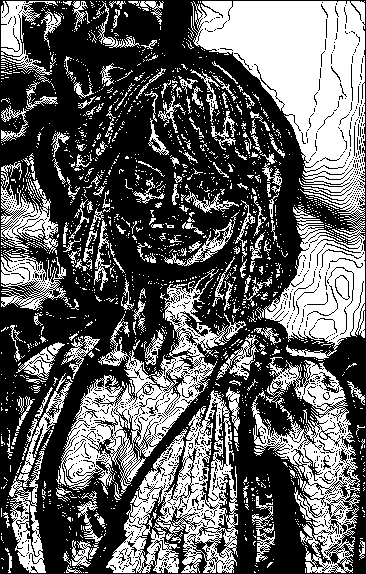

In [654]:
hysteresis_img = hysteresis(threshold_img, weak, strong)
cv2_imshow(hysteresis_img)

In [701]:
def detect(img, kernel_size=15, sigma=1.4, low_threshold_ratio=0.05, high_threshold_ratio=0.09, weak=25, strong=255):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_smoothed = ndimage.convolve(img, gaussian_kernel(kernel_size, sigma))
  gradient, theta = sobel_filters(img_smoothed)
  # Apply median filter to the gradient image
  gradient = median_filter(smoothed_img, kernel_size)
  non_max_img = non_max_suppression(gradient, theta)
  threshold_img = threshold(non_max_img, low_threshold_ratio, high_threshold_ratio)[0]
  img_final = hysteresis(threshold_img, weak, strong)

  return img_final

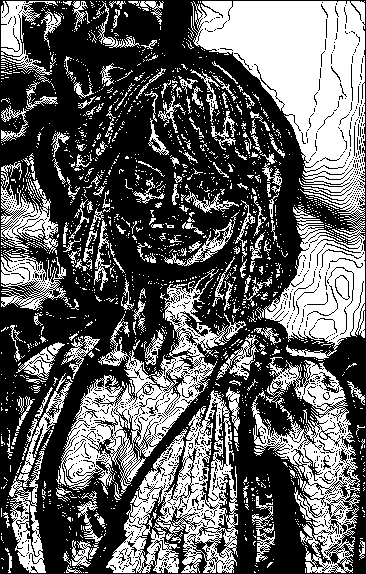

In [702]:
img = cv2.imread('/content/edge_detection.jpg')
img_final = detect(img, kernel_size=5, sigma=1.4, low_threshold_ratio=0.05, high_threshold_ratio=0.09, weak=25, strong=255)
cv2_imshow(img_final)

# Text preprocessing

Text preprocessing typically involves the following steps:
1.  Expand Contractions
Contraction is the shortened form of a word like don’t stands for do not, aren’t stands for are not.
2.  Lowercasing
Python is a case sensitive programming language. Therefore, to avoid any issues and ensure consistency in the processing of the text, we convert all the text to lowercase.
3.  Removing Punctuation & Special Characters
It is essential to remove any characters that are not considered as words or whitespace from the text dataset.
4. Remove words and digits containing digits
It is important to remove all numerical digits from the text dataset. This is because, in most cases, numerical values do not provide any significant meaning to the text analysis process.
5.  Stop-Words Removal
Stopwords refer to the most commonly occurring words in any natural language.
For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document
6.  Removal of URLs and emails (paraphrase text)
we may need to modify some text or change the pattern to a particular string which makes it easy to identify like we can match the pattern of email ids and change it to string like email address.
When building a model, URLs are typically not relevant and can be removed from the text data.
7.  Removal of HTML Tags
Removal of HTML Tags is a text preprocessing step used to clean text data from HTML documents. When working with text data obtained from web pages or other HTML-formatted sources, the text may contain HTML tags, which are not desirable for text analysis or machine learning models.
8.  Stemming & Lemmatization
Stemming is a process to reduce the word to its root stem for example run, running, runs, runed derived from the same word as run. basically stemming do is remove the prefix or suffix from word like ing, s, es, etc. NLTK library is used to stem the words. The stemming technique is not used for production purposes because it is not so efficient technique and most of the time it stems the unwanted words. So, to solve the problem another technique came into the market as Lemmatization.
There are various algorithms that can be used for stemming,
*   Porter Stemmer algorithm
*   Snowball Stemmer algorithm
*   Lovins Stemmer algorithm
Lemmatization is similar to stemming, used to stem the words into root word but differs in working. Actually, Lemmatization is a systematic way to reduce the words into their lemma by matching them with a language dictionary.
9.  Remove Extra Spaces
Most of the time text data contain extra spaces or while performing the above preprocessing techniques more than one space is left between the text so we need to control this problem. regular expression library performs well to solve this problem.

**Tokenization** is the process of breaking up the paragraph into smaller units such as sentences or words. Each unit is then considered as an individual token. The fundamental principle of Tokenization is to try to understand the meaning of the text by analyzing the smaller units or tokens that constitute the paragraph

*   https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
*   https://ayselaydin.medium.com/1-text-preprocessing-techniques-for-nlp-37544483c007
*   https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
*   https://www.analyticsvidhya.com/blog/2021/09/essential-text-pre-processing-techniques-for-nlp/

